In [31]:
import pandas as pd
from openai import OpenAI
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
import re
import numpy as np

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Load CSV file
df = pd.read_csv('./csv/ocr/dankmemes-top-ocr.csv')

config_json = json.load(open('config.json'))
openai = OpenAI(
    api_key=config_json['openai_key']
)

# Function to get OpenAI text embeddings
def get_openai_embedding(text, model="text-embedding-ada-002"):
    print(text)
    response = openai.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

def clean(t):
    text = str(t).lower()
    text = re.sub(r"\[(.*?)\]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\w+…|…", "", text)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)
    text = re.sub(r"made with me matic", " ", text)
    text = re.sub(r"me matic", " ", text)
    text = re.sub(r"img flip com", " ", text)
    text = re.sub(r"img i ipcom", " ", text)
    text = re.sub(r"flip com", " ", text)
    text = re.sub(r"img lip com", " ", text)
    text = re.sub(r"img lip", " ", text)
    text = re.sub(r"lip com", " ", text)
    text = re.sub(r"tenor", " ", text)
    text = re.sub(r"reddito rs", "redditors", text)
    tokens = text.split()
    tokens = ["" if t.isdigit() else t for t in tokens]
    tokens = [t for t in tokens if len(t) > 1]
    
    return " ".join(tokens)

df['combined_text'] = df['text'].fillna('') + ' ' + df['caption'].fillna('')
df['combined_text'] = df['combined_text'].apply(clean)


In [33]:
import os

# Check if embeddings file exists, otherwise compute and save
embeddings_file = 'openai_embeddings.csv'

if not os.path.exists(embeddings_file):
    # Apply OpenAI embedding to the 'combined_text' column
    df['embedding'] = df['combined_text'].apply(lambda x: get_openai_embedding(x))

    # Convert the list embeddings into a 2D NumPy array
    embeddings_array = np.vstack(df['embedding'])

    # Save the embeddings to a CSV file
    df.to_csv(embeddings_file, index=False)
else:
    # Load embeddings from the existing file
    df = pd.read_csv(embeddings_file)

retail workers this week take that you ostrich skeleton clearance tis the season
british when they see people fighting over some lines the ydrew2oo years ago im sure its more complicated but still
dog owners its purebred pembroke welsh corgi from ay akcbreeder6generanons of pedigree cat owners found him in trash can his name is spot dog goes woof. cat goes feed me.
me no problem narrator but it was all problemo something is wrong, can feel it
youtube whe fave because they dont allow ad blockers to block the most useless ads in existance mean, car ads when don't even have drivers licence?!
modern cartoons arent violent like used to be modern cartoons they silly goose activities
me the non binary pers oh just called dude don identify as male dont care literally dont have penis still dont care name better word to refer to people, i'll wait
ready to gogo go yes aml 9ooo oh yeah
nnn advocates believing vaccines are deadly and the earth is flat nnn advocates thinking semen retention is real 

In [49]:
# Extract the embeddings into a NumPy array
embeddings_array = np.vstack(df['embedding'])

# Calculate inertia for different values of k
inertia = []
k_values = range(1, 30)
for k in k_values:  # You can adjust the range of k
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.vstack(df['embedding']))
    inertia.append(kmeans.inertia_)

/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

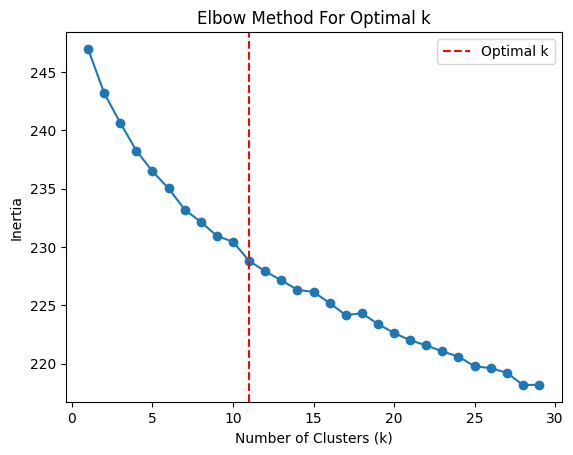

/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=11, random_state=42)

In [73]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal k')
plt.legend()
plt.show()

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(np.vstack(df['embedding']))

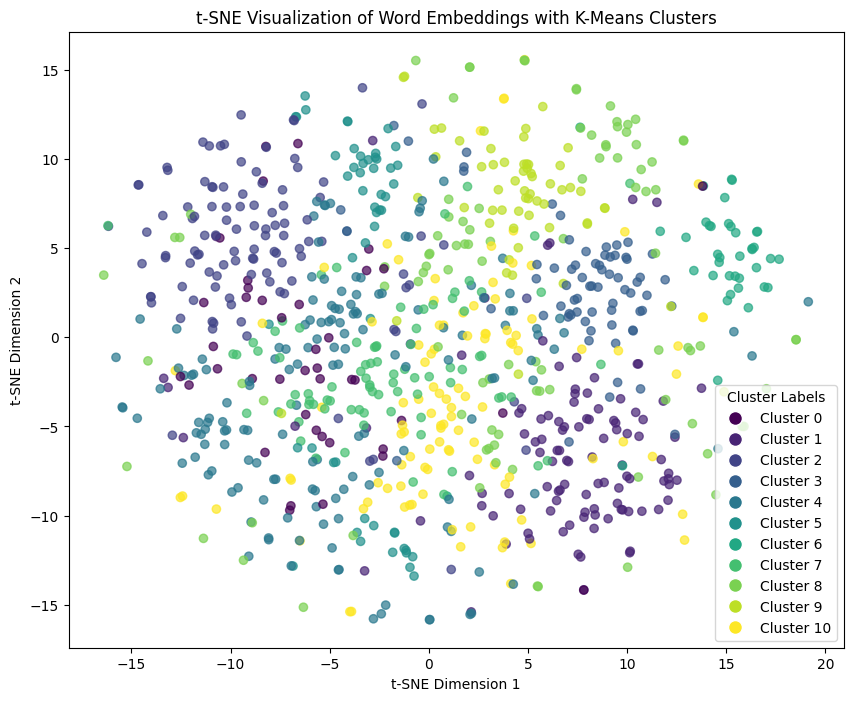

In [74]:
# Apply t-SNE to the embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=80)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Add the 2D embeddings to the DataFrame
df['tsne_x'] = embeddings_2d[:, 0]
df['tsne_y'] = embeddings_2d[:, 1]

# Visualize the clusters with t-SNE and annotate with label names
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['tsne_x'], df['tsne_y'], c=kmeans.labels_, cmap='viridis', alpha=0.7)

# Annotate with label names
# for i, txt in enumerate(df['combined_text'].sample(10)):  # You can adjust the number of samples
#    plt.annotate(txt, (df['tsne_x'].iloc[i], df['tsne_y'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

# Add legend with label names
legend_labels = {label: f'Cluster {label}' for label in set(kmeans.labels_)}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=legend_labels[label]) for label in set(kmeans.labels_)]
plt.legend(handles=legend_handles, title='Cluster Labels')

plt.title('t-SNE Visualization of Word Embeddings with K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

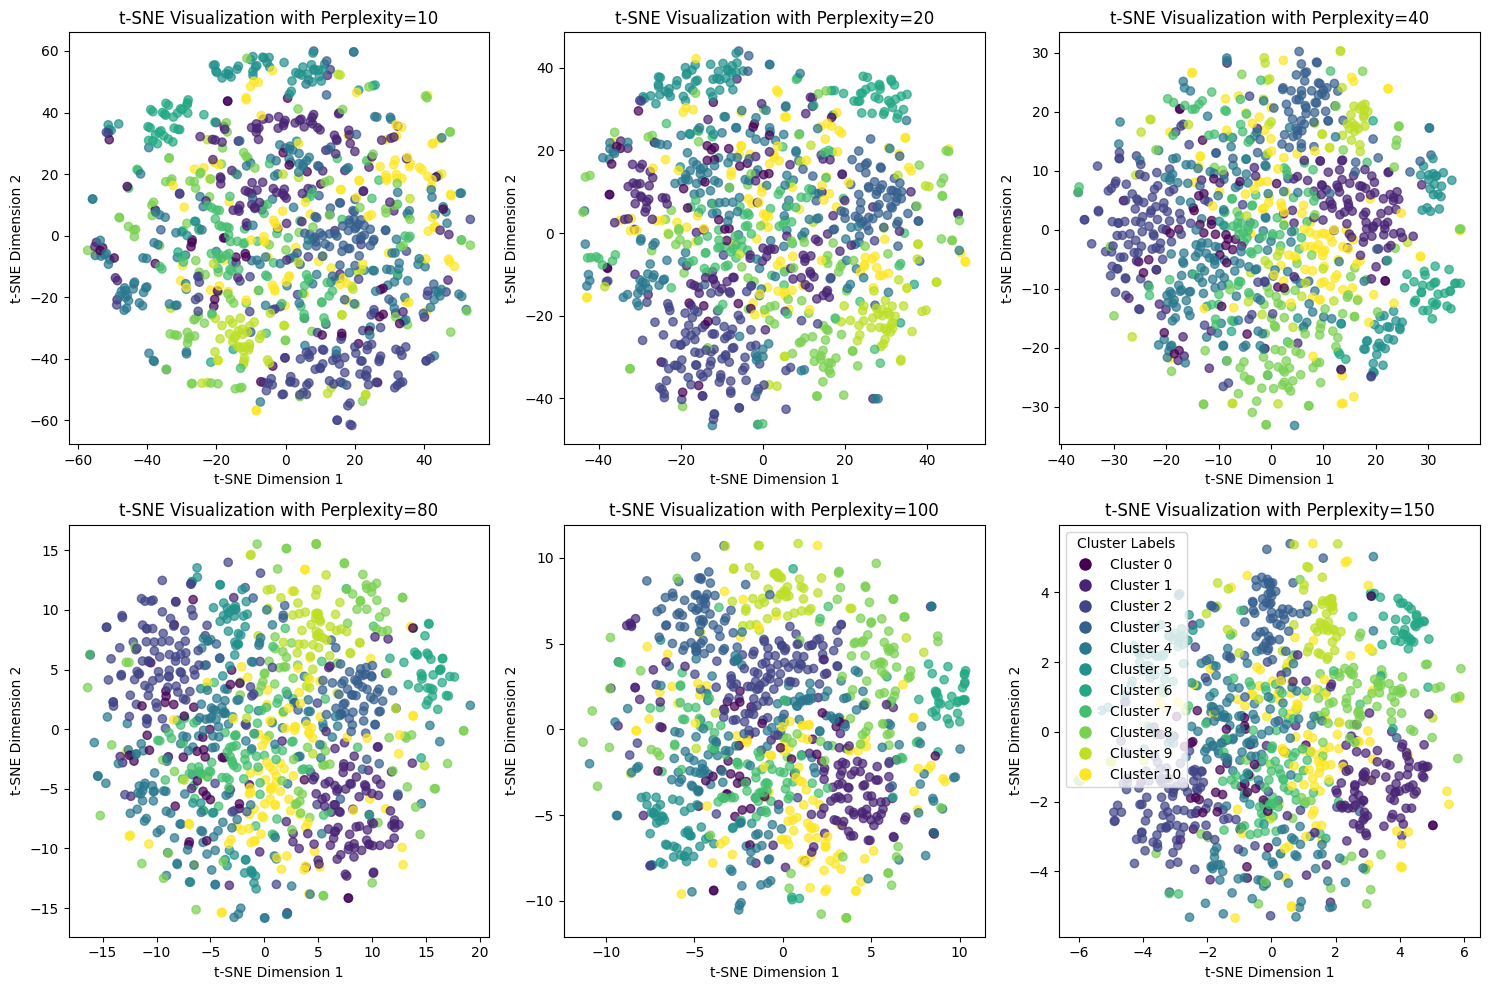

In [75]:
# Function to visualize t-SNE with different perplexity values
def visualize_tsne_with_perplexity(embeddings_array, perplexity_values):
    num_perplexities = len(perplexity_values)

    # Adjust the number of rows and columns for subplots
    num_rows = 2
    num_cols = int(np.ceil(num_perplexities / num_rows))

    plt.figure(figsize=(15, 10))

    for i, perplexity in enumerate(perplexity_values, start=1):
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings_array)

        plt.subplot(num_rows, num_cols, i)
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Visualization with Perplexity={perplexity}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')

        # Annotate with label names (optional)
        # for j, txt in enumerate(df['combined_text'].sample(10)):  # You can adjust the number of samples
        #     plt.annotate(txt, (embeddings_2d[j, 0], embeddings_2d[j, 1]), textcoords="offset points", xytext=(0,5), ha='center')

    # Add legend with label names
    legend_labels = {label: f'Cluster {label}' for label in set(kmeans.labels_)}
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=legend_labels[label]) for label in set(kmeans.labels_)]
    plt.legend(handles=legend_handles, title='Cluster Labels')

    plt.tight_layout()
    plt.show()

# Perplexity values to visualize
perplexity_values = [10, 20, 40, 80, 100, 150]

# Visualize t-SNE with different perplexity values
visualize_tsne_with_perplexity(embeddings_array, perplexity_values)


In [84]:

# Get centroids of each cluster
centroids = kmeans.cluster_centers_

# Function to find representative samples from each cluster
def print_cluster_representatives(cluster_id, num_representatives=5):
    print(f"Cluster {cluster_id + 1} representatives:")
    # Find indices of data points in the cluster
    cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]

    # Calculate distances from centroid for each data point in the cluster
    distances = np.linalg.norm(embeddings_array[cluster_indices] - centroids[cluster_id], axis=1)

    # Get indices of num_representatives samples with smallest distances
    representative_indices = cluster_indices[np.argsort(distances)[:num_representatives]]

    # Print representative samples
    for i, index in enumerate(representative_indices, start=1):
        print(" ".join(f"{df.iloc[index]['caption']}: {df.iloc[index]['text']}".split("\n")))
    
    print("-" * 10)

# Print representatives from each cluster
for cluster_id in range(optimal_k):
    print_cluster_representatives(cluster_id)


Cluster 1 representatives:
I'm blue...: family and friends whats wrong you look up set me no im good also me
I'll be there for you: 1 aa grinnman1m blg adult 1 can doth ls de dua matte w perry fren p
I'm all eyes: me giving my far right uncle alcohol the family reunion should now become a lot more interesting
I've made a huge mistake.: me coming out of my room thinking they left my mom introducing me to the guests ia de with me matic
We all gonna have some fun: the teacher tells everyone to pick a lab partner and your friend gives you this look
----------
Cluster 2 representatives:
Sad but true: humanity inventing newer ways to discriminate against each other made with me matic
Didn't see that one coming: geat18 knowing that a surprisingly war ge amount of old people are racist ca3o cn owing tha a surprisingly large atountof18 year old people are racist
Im sure its more complicated but still: british when they see people fighting over some lines the ydrew2oo years ago
You will get it o